In [1]:
from keras.models import Sequential
from keras.utils import np_utils, plot_model
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.initializers import glorot_uniform, orthogonal, TruncatedNormal
from keras.callbacks import EarlyStopping
from keras.layers.recurrent import GRU, SimpleRNN

import pandas as pd #行列計算
import numpy as np #行列計算
import math #数値計算
import itertools #順列・組み合わせ
import time
import talib as ta # テクニカル指標

import matplotlib.pyplot as plt #グラフ
import winsound # ビープ音
import os

from df_method import rise_fall_rate, moving_average, GCDC, df_shift, add_data, RSI, Z_score_normalization, Min_Max_normalization

Using TensorFlow backend.


In [3]:
is_debug = True
csv_path = './csv_realtime/'
x_days_later = 1 # '1', '2', '7', '30', '365'
learning_model = 'RNN' #['RNN', 'LSTM', 'GRU']
start_date = '2009-3-10' #  '1960', '1970', '1980', '1990', '2000', '2010'
end_date = '2018-10-31'# 終点年月日

min_maxlen = 100
max_maxlen = 1000
min_n_hidden = 100
max_n_hidden = 500

target_name = 'USD_JPY_diff'# 'nikkei_Close', 'nikkei_diff', 'USD_JPY'
max_score = 0 # 最高正答率

In [6]:
# テクニカル指標を求めるために使用-----------------------------------------
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col=0, parse_dates=True)
df_close = df['USD_JPY_Close']

# 指数移動平均----------------------------------------------------
sma5 = ta.SMA(df_close, timeperiod=5)
sma25 = ta.SMA(df_close, timeperiod=25)
sma75 = ta.SMA(df_close, timeperiod=75)
sma5.name = 'sma5'
sma25.name = 'sma25'
sma75.name = 'sma75'
SMA = pd.DataFrame(sma5)
SMA = SMA.join(sma25)
SMA = SMA.join(sma75)
SMA = SMA.dropna()
#df_list.append(SMA)
print(SMA)

                sma5      sma25       sma75
Date                                       
1988-06-16  125.6320  125.17000  125.462133
1988-06-17  125.8180  125.20960  125.424000
1988-06-20  126.0540  125.26440  125.404000
1988-06-21  126.0360  125.29480  125.385067
1988-06-22  126.5520  125.45240  125.394933
1988-06-23  127.1540  125.60080  125.403867
1988-06-24  128.0960  125.82640  125.446267
1988-06-27  129.0720  126.09280  125.503333
1988-06-28  130.3900  126.44440  125.578400
1988-06-29  131.1340  126.77240  125.646400
1988-06-30  132.0480  127.11800  125.705600
1988-07-01  132.8400  127.49880  125.792400
1988-07-04  133.6800  127.91360  125.904667
1988-07-05  133.8800  128.26560  125.998000
1988-07-06  133.9480  128.56720  126.080533
1988-07-07  133.8680  128.82880  126.177067
1988-07-08  133.6040  129.11080  126.283733
1988-07-11  133.1000  129.39600  126.404667
1988-07-12  132.7620  129.67160  126.501200
1988-07-13  132.7140  129.95760  126.604667
1988-07-14  132.8260  130.30560 

In [11]:
SMA_diff = sma5 - sma25
SMA_diff = SMA_diff.dropna()
print(SMA_diff)

Date
1988-04-07   -1.42040
1988-04-08   -0.95120
1988-04-11   -0.45320
1988-04-12   -0.10840
1988-04-13    0.04800
1988-04-14   -0.19000
1988-04-15   -0.40280
1988-04-18   -0.71200
1988-04-19   -1.08600
1988-04-20   -1.39520
1988-04-21   -1.06640
1988-04-22   -0.77520
1988-04-25   -0.61040
1988-04-26   -0.38120
1988-04-27   -0.18120
1988-04-28   -0.11720
1988-04-29   -0.05000
1988-05-02   -0.05200
1988-05-03   -0.02600
1988-05-04   -0.04800
1988-05-05    0.03360
1988-05-06   -0.07200
1988-05-09   -0.10440
1988-05-10   -0.22920
1988-05-11   -0.21080
1988-05-12   -0.28000
1988-05-13   -0.24320
1988-05-16   -0.16240
1988-05-17    0.13800
1988-05-18    0.28960
               ...   
2018-10-01    1.36240
2018-10-02    1.40480
2018-10-03    1.64880
2018-10-04    1.63680
2018-10-05    1.53440
2018-10-08    1.30040
2018-10-09    1.09560
2018-10-10    0.61880
2018-10-11    0.20760
2018-10-12   -0.14240
2018-10-15   -0.46080
2018-10-16   -0.62880
2018-10-17   -0.61600
2018-10-18   -0.62000
2018-

In [13]:
# ラベルデータを作成する列
target = SMA_diff#df_x[target_name]
            
# 空のデータフレーム作成
df_t = pd.DataFrame(index=SMA_diff.index, columns=['positive', 'negative'])
df_t = df_t.fillna(0) #０で埋める

# 条件にあった値を置換する
df_t.loc[0 <= target, 'positive'] = 1
df_t.loc[target < 0, 'negative'] = 1

# データを整える
#df_t = df_t.shift(-1 * x_days_later, axis=0)#予測先日数分だけ縦にずらす
#df_t = df_t.drop(df_t.index[-1*x_days_later:], axis=0)#ラベルデータ末尾の行を削除
#df_x = df_x.drop(df_x.index[-1*x_days_later:], axis=0)#学習データの末尾の行を削除

print(df_t)

            positive  negative
Date                          
1988-04-07         0         1
1988-04-08         0         1
1988-04-11         0         1
1988-04-12         0         1
1988-04-13         1         0
1988-04-14         0         1
1988-04-15         0         1
1988-04-18         0         1
1988-04-19         0         1
1988-04-20         0         1
1988-04-21         0         1
1988-04-22         0         1
1988-04-25         0         1
1988-04-26         0         1
1988-04-27         0         1
1988-04-28         0         1
1988-04-29         0         1
1988-05-02         0         1
1988-05-03         0         1
1988-05-04         0         1
1988-05-05         1         0
1988-05-06         0         1
1988-05-09         0         1
1988-05-10         0         1
1988-05-11         0         1
1988-05-12         0         1
1988-05-13         0         1
1988-05-16         0         1
1988-05-17         1         0
1988-05-18         1         0
...     

In [64]:
target = df_close[SMA.index[0]:]
print(SMA['sma5'] - target)

Date
1988-06-16    0.0920
1988-06-17    0.0980
1988-06-20   -0.2060
1988-06-21   -0.3440
1988-06-22   -2.3080
1988-06-23   -1.3960
1988-06-24   -2.3340
1988-06-27   -2.0680
1988-06-28   -2.5800
1988-06-29   -1.4460
1988-06-30   -1.0720
1988-07-01   -1.5500
1988-07-04   -1.6600
1988-07-05   -0.0900
1988-07-06    1.0280
1988-07-07    1.1480
1988-07-08    0.5340
1988-07-11    0.2800
1988-07-12    0.4820
1988-07-13    0.0340
1988-07-14   -0.4540
1988-07-15   -2.1400
1988-07-18   -0.7760
1988-07-19    0.6620
1988-07-20    0.2300
1988-07-21    2.0000
1988-07-22    1.8880
1988-07-25    0.0660
1988-07-26   -0.1820
1988-07-27    0.1800
               ...  
2018-10-01   -0.6160
2018-10-02   -0.1840
2018-10-03   -0.6660
2018-10-04    0.0380
2018-10-05    0.2500
2018-10-08    0.5820
2018-10-09    0.7160
2018-10-10    0.9300
2018-10-11    0.7160
2018-10-12    0.3720
2018-10-15    0.5000
2018-10-16   -0.1120
2018-10-17   -0.4340
2018-10-18    0.0220
2018-10-19   -0.2680
2018-10-22   -0.2980
2018-10-

In [18]:
# ★RSI
RSI = ta.RSI(df_close, timeperiod=14)
RSI.name = 'RSI'
#df_list['RSI'] = RSI
RSI = RSI.dropna()
print(RSI)

Date
1988-03-24    29.497354
1988-03-25    27.869640
1988-03-28    23.393835
1988-03-29    34.469805
1988-03-30    33.977666
1988-03-31    31.402547
1988-04-01    29.914702
1988-04-04    31.875527
1988-04-05    40.865129
1988-04-06    46.045795
1988-04-07    44.157171
1988-04-08    44.301892
1988-04-11    48.999110
1988-04-12    51.785658
1988-04-13    49.563690
1988-04-14    35.185290
1988-04-15    37.530033
1988-04-18    39.739612
1988-04-19    39.739612
1988-04-20    39.587370
1988-04-21    40.808401
1988-04-22    43.978768
1988-04-25    43.024271
1988-04-26    46.288330
1988-04-27    45.145651
1988-04-28    42.664507
1988-04-29    48.025810
1988-05-02    45.831665
1988-05-03    48.785904
1988-05-04    45.122406
                ...    
2018-10-01    73.099760
2018-10-02    67.947604
2018-10-03    73.724450
2018-10-04    64.747843
2018-10-05    61.906712
2018-10-08    55.871873
2018-10-09    52.647766
2018-10-10    45.921111
2018-10-11    44.618826
2018-10-12    45.097897
2018-10-15 

In [20]:
# ラベルデータを作成する列
target = RSI#df_x[target_name]
            
# 空のデータフレーム作成
df_t = pd.DataFrame(index=RSI.index, columns=['over70', 'neutral', 'less30'])
df_t = df_t.fillna(0) #０で埋める

# 条件にあった値を置換する
df_t.loc[70 <= target, 'over70'] = 1
df_t.loc[(30 < target) & (target < 70), 'neutral'] = 1
df_t.loc[target <= 30, 'less30'] = 1

# データを整える
#df_t = df_t.shift(-1 * x_days_later, axis=0)#予測先日数分だけ縦にずらす
#df_t = df_t.drop(df_t.index[-1*x_days_later:], axis=0)#ラベルデータ末尾の行を削除
#df_x = df_x.drop(df_x.index[-1*x_days_later:], axis=0)#学習データの末尾の行を削除

print(df_t)

            over70  neutral  less30
Date                               
1988-03-24       0        0       1
1988-03-25       0        0       1
1988-03-28       0        0       1
1988-03-29       0        1       0
1988-03-30       0        1       0
1988-03-31       0        1       0
1988-04-01       0        0       1
1988-04-04       0        1       0
1988-04-05       0        1       0
1988-04-06       0        1       0
1988-04-07       0        1       0
1988-04-08       0        1       0
1988-04-11       0        1       0
1988-04-12       0        1       0
1988-04-13       0        1       0
1988-04-14       0        1       0
1988-04-15       0        1       0
1988-04-18       0        1       0
1988-04-19       0        1       0
1988-04-20       0        1       0
1988-04-21       0        1       0
1988-04-22       0        1       0
1988-04-25       0        1       0
1988-04-26       0        1       0
1988-04-27       0        1       0
1988-04-28       0        1 

In [23]:
upper1, middle1, lower1 = ta.BBANDS(df_close, timeperiod=5, nbdevup=1, nbdevdn=1)
upper2, middle2, lower2 = ta.BBANDS(df_close, timeperiod=5, nbdevup=2, nbdevdn=2)
upper3, middle3, lower3 = ta.BBANDS(df_close, timeperiod=5, nbdevup=3, nbdevdn=3)
upper3.name = 'upper3'
upper2.name = 'upper2'
upper1.name = 'upper1'
middle1.name = 'middle'
lower1.name = 'lower1'
lower2.name = 'lower2'
lower3.name = 'lower3'
BB = pd.DataFrame(upper3)
BB = BB.join(upper2)
BB = BB.join(upper1)
BB = BB.join(middle1)
BB = BB.join(lower1)
BB = BB.join(lower2)
BB = BB.join(lower3)
BB = BB.dropna()
#df_list['BB'] = BB
print(BB)

                upper3      upper2      upper1    middle      lower1  \
Date                                                                   
1988-03-10  128.936837  128.633891  128.330946  128.0280  127.725054   
1988-03-11  128.616531  128.331688  128.046844  127.7620  127.477156   
1988-03-14  128.961530  128.501687  128.041843  127.5820  127.122157   
1988-03-15  128.848970  128.395980  127.942990  127.4900  127.037010   
1988-03-16  128.354524  128.023683  127.692841  127.3620  127.031159   
1988-03-17  129.365514  128.751009  128.136505  127.5220  126.907495   
1988-03-18  129.479170  128.868780  128.258390  127.6480  127.037610   
1988-03-21  129.445542  128.850361  128.255181  127.6600  127.064819   
1988-03-22  129.538316  128.887544  128.236772  127.5860  126.935228   
1988-03-23  129.651341  128.912894  128.174447  127.4360  126.697553   
1988-03-24  129.103045  128.334030  127.565015  126.7960  126.026985   
1988-03-25  128.627135  127.829423  127.031712  126.2340  125.43

In [57]:
print(target)

Date
1988-03-10    127.880
1988-03-11    127.250
1988-03-14    126.860
1988-03-15    127.340
1988-03-16    127.480
1988-03-17    128.680
1988-03-18    127.880
1988-03-21    126.920
1988-03-22    126.970
1988-03-23    126.730
1988-03-24    125.480
1988-03-25    125.070
1988-03-28    123.750
1988-03-29    125.040
1988-03-30    124.920
1988-03-31    124.280
1988-04-01    123.890
1988-04-04    124.110
1988-04-05    125.220
1988-04-06    125.970
1988-04-07    125.630
1988-04-08    125.650
1988-04-11    126.310
1988-04-12    126.730
1988-04-13    126.410
1988-04-14    123.580
1988-04-15    123.920
1988-04-18    124.240
1988-04-19    124.240
1988-04-20    124.210
               ...   
2018-10-01    113.960
2018-10-02    113.670
2018-10-03    114.510
2018-10-04    113.910
2018-10-05    113.700
2018-10-08    113.220
2018-10-09    112.940
2018-10-10    112.280
2018-10-11    112.140
2018-10-12    112.180
2018-10-15    111.760
2018-10-16    112.230
2018-10-17    112.620
2018-10-18    112.170
2018-

In [61]:
# ラベルデータを作成する列
print(BB.index[0])
target = df_close[BB.index[0]:]
    
# 空のデータフレーム作成
df_t = pd.DataFrame(index=BB.index, columns=['over3', 'over2', 'over1', 'over0', 'less0', 'less1', 'less2', 'less3'])
df_t = df_t.fillna(0) #０で埋める
#print(df_t)

# 条件にあった値を置換する
df_t.loc[BB["upper3"] <= target, 'over3'] = 1
df_t.loc[(BB["upper2"] <= target) & (target < BB["upper3"]), 'over2'] = 1
df_t.loc[(BB["upper1"] <= target) & (target < BB["upper2"]), 'over1'] = 1
df_t.loc[(BB["middle"] <= target) & (target < BB["upper1"]), 'over0'] = 1
df_t.loc[(BB["lower1"] <= target) & (target < BB["middle"]), 'less0'] = 1
df_t.loc[(BB["lower2"] <= target) & (target < BB["lower1"]), 'less1'] = 1
df_t.loc[(BB["lower3"] <= target) & (target < BB["lower2"]), 'less2'] = 1
df_t.loc[target < BB["lower3"], 'less3'] = 1

print(df_t)

1988-03-10 00:00:00
            over3  over2  over1  over0  less0  less1  less2  less3
Date                                                              
1988-03-10      0      0      0      0      1      0      0      0
1988-03-11      0      0      0      0      0      1      0      0
1988-03-14      0      0      0      0      0      1      0      0
1988-03-15      0      0      0      0      1      0      0      0
1988-03-16      0      0      0      1      0      0      0      0
1988-03-17      0      0      1      0      0      0      0      0
1988-03-18      0      0      0      1      0      0      0      0
1988-03-21      0      0      0      0      0      1      0      0
1988-03-22      0      0      0      0      1      0      0      0
1988-03-23      0      0      0      0      1      0      0      0
1988-03-24      0      0      0      0      0      1      0      0
1988-03-25      0      0      0      0      0      1      0      0
1988-03-28      0      0      0      0    

            positive  negative
Date                          
1988-03-16         1         0
1988-03-17         1         0
1988-03-18         1         0
1988-03-21         0         1
1988-03-22         0         1
1988-03-23         0         1
1988-03-24         0         1
1988-03-25         0         1
1988-03-28         0         1
1988-03-29         1         0
1988-03-30         1         0
1988-03-31         1         0
1988-04-01         0         1
1988-04-04         0         1
1988-04-05         1         0
1988-04-06         1         0
1988-04-07         1         0
1988-04-08         1         0
1988-04-11         0         1
1988-04-12         1         0
1988-04-13         1         0
1988-04-14         0         1
1988-04-15         0         1
1988-04-18         0         1
1988-04-19         0         1
1988-04-20         1         0
1988-04-21         1         0
1988-04-22         1         0
1988-04-25         1         0
1988-04-26         1         0
...     

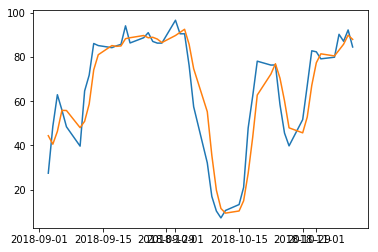

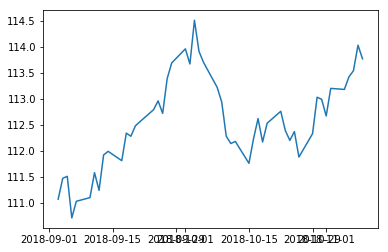

In [105]:
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col=0, parse_dates=True)
df_close = df['USD_JPY_Close']
k, d = ta.STOCH(high=df['USD_JPY_High'], low=df['USD_JPY_Low'], close=df['USD_JPY_Close'])
k = k.dropna()
d = d.dropna()
#print(k)
#print(d)
STOCH_diff = k - d
target = STOCH_diff

# 空のデータフレーム作成
df_t = pd.DataFrame(index=STOCH_diff.index, columns=['positive', 'negative'])
df_t = df_t.fillna(0) #０で埋める

# 条件にあった値を置換する
df_t.loc[0 <= target, 'positive'] = 1
df_t.loc[target < 0, 'negative'] = 1

print(df_t)

fig, ax = plt.subplots()
ax.plot(k['2018-9-1':])
ax.plot(d['2018-9-1':])
fig, ax = plt.subplots()
ax.plot(df_close['2018-9-1':])

In [3]:
x = {'a': 1,
     'b': 2,
     'c' : 3}
x = {}
x['a'] = 1
x['b'] = 2
x['c'] = 3

# キーを取得
for i in x:
    print(i)
    
# キーを取得
for i in x.keys():
    print(i)

# 要素を取得
for i in x.values():
    print(i)

# キーと要素を取得
for i, j in x.items():
    print(i, j)

a
b
c
a
b
c
1
2
3
a 1
b 2
c 3
